# CPU-friendly Brain Tumor MRI Notebook (Lite)

A lightweight copy of the original notebook with:
- Downsampled dataframes
- Lighter preprocessing and smaller images (128×128)
- Tiny, frozen transfer head (MobileNetV2)
- Fewer epochs and simple CPU workers


In [3]:
# 1. Imports
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")


## 2. Preprocessing
### 2.1 Load data


In [4]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])
    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})


def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    return pd.DataFrame({'Class Path': class_paths, 'Class': classes})


tr_df = train_df('input_data/Training')
ts_df = test_df('input_data/Testing')

# Split test into valid/test
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])


### 2.2 Downsample the dataframes (small, balanced subset)


In [5]:
# Keep at most N samples per class for a quick CPU demo
N = 80  # adjust between 40–200 depending on speed vs. accuracy


def balance_limit(df, n):
    return (df.groupby('Class', group_keys=False)
              .apply(lambda g: g.sample(n=min(len(g), n), random_state=42))
              .reset_index(drop=True))


tr_df_small = balance_limit(tr_df, N)
valid_df_small = balance_limit(valid_df, max(20, N//4))
ts_df_small = balance_limit(ts_df, max(20, N//4))

print('Subset sizes:', len(tr_df_small), len(valid_df_small), len(ts_df_small))


Subset sizes: 320 80 80


### 2.3 Data generators with lighter preprocessing and smaller images


In [6]:
batch_size = 8
img_size = (128, 128)

_gen = ImageDataGenerator(rescale=1/255.0)  # light preprocessing only
ts_only = ImageDataGenerator(rescale=1/255.0)

tr_gen = _gen.flow_from_dataframe(tr_df_small, x_col='Class Path', y_col='Class',
                                  batch_size=batch_size, target_size=img_size, shuffle=True)

valid_gen = _gen.flow_from_dataframe(valid_df_small, x_col='Class Path', y_col='Class',
                                     batch_size=batch_size, target_size=img_size)

ts_gen = ts_only.flow_from_dataframe(ts_df_small, x_col='Class Path', y_col='Class',
                                     batch_size=batch_size, target_size=img_size, shuffle=False)

class_dict = tr_gen.class_indices
classes = list(class_dict.keys())


Found 320 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.
Found 80 validated image filenames belonging to 4 classes.


## 3. Model: tiny, frozen transfer head (MobileNetV2)


In [7]:
img_shape = (128, 128, 3)
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',
                                               input_shape=img_shape, pooling='avg')
for layer in base_model.layers:
    layer.trainable = False  # freeze backbone for fast CPU training

model = Sequential([
    base_model,
    Dropout(0.2),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Training (fewer epochs, simple workers)


In [8]:
hist = model.fit(
    tr_gen,
    epochs=6,               # quick CPU demo
    validation_data=valid_gen,
    shuffle=True,
)
history = hist.history
_ = history.keys()


Epoch 1/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.4219 - loss: 1.3317 - precision: 0.4740 - recall: 0.2562 - val_accuracy: 0.5875 - val_loss: 0.9761 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 2/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6406 - loss: 0.9455 - precision: 0.7241 - recall: 0.4594 - val_accuracy: 0.6500 - val_loss: 0.8326 - val_precision: 0.7660 - val_recall: 0.4500
Epoch 3/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6969 - loss: 0.7784 - precision: 0.8069 - recall: 0.5875 - val_accuracy: 0.6625 - val_loss: 0.7726 - val_precision: 0.7500 - val_recall: 0.5250
Epoch 4/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7688 - loss: 0.6759 - precision: 0.8083 - recall: 0.6719 - val_accuracy: 0.7250 - val_loss: 0.7074 - val_precision: 0.7869 - val_recall: 0.6000
Epoch 5/6
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8188 - loss: 0.5611 - precision: 0.8810 - recall: 0.7406 - val_accuracy: 0.7375 - val_loss: 0.6814 - val

## 5. Quick evaluation


In [9]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8594 - loss: 0.4615 - precision: 0.9275 - recall: 0.8000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7250 - loss: 0.6671 - precision: 0.7778 - recall: 0.6125
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6875 - loss: 0.6783 - precision: 0.7705 - recall: 0.5875
Train Loss: 0.4615
Train Accuracy: 85.94%
--------------------
Validation Loss: 0.6671
Validation Accuracy: 72.50%
--------------------
Test Loss: 0.6783
Test Accuracy: 68.75%


## 6. Visualize model performance (training curves)


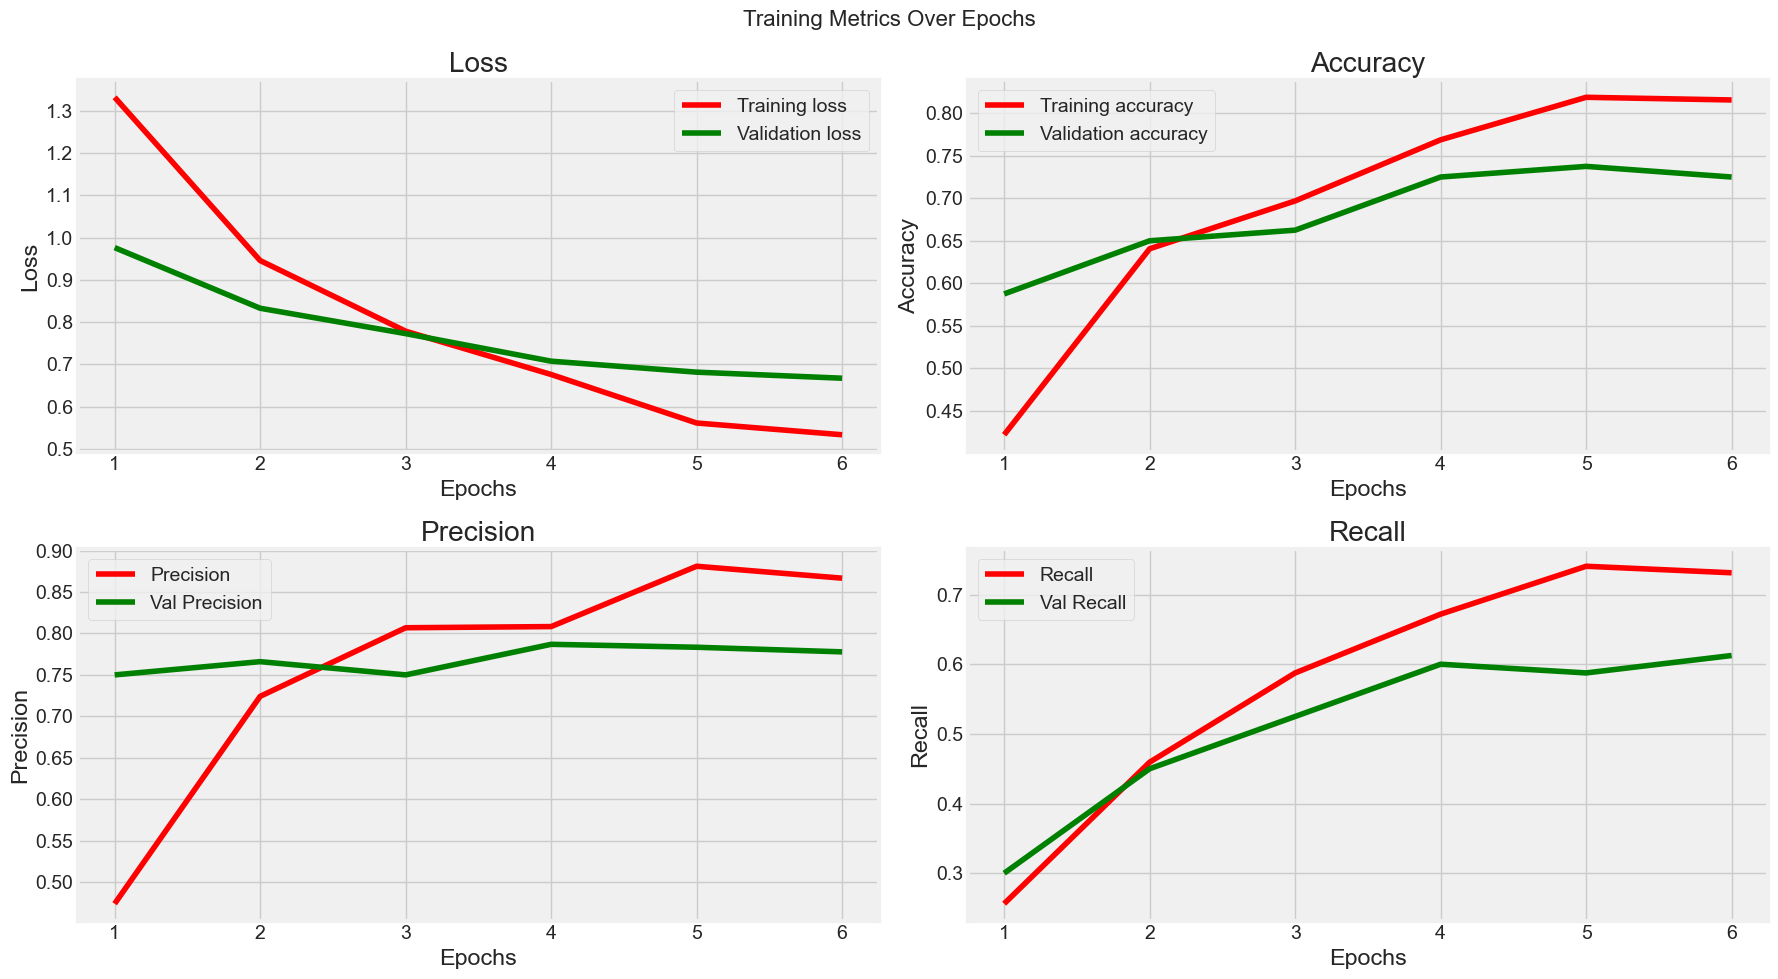

In [10]:
# Safely extract metrics (in case some are missing)
tr_acc = history.get('accuracy', [])
tr_loss = history.get('loss', [])
tr_per = history.get('precision', [])
tr_recall = history.get('recall', [])
val_acc = history.get('val_accuracy', [])
val_loss = history.get('val_loss', [])
val_per = history.get('val_precision', [])
val_recall = history.get('val_recall', [])

# Determine number of epochs from available series
num_epochs = max(len(tr_acc), len(tr_loss), len(val_acc), len(val_loss))
Epochs = [i + 1 for i in range(num_epochs)]

plt.figure(figsize=(18, 10))
plt.style.use('fivethirtyeight')

# Loss
plt.subplot(2, 2, 1)
if len(tr_loss):
    plt.plot(Epochs[:len(tr_loss)], tr_loss, 'r', label='Training loss')
if len(val_loss):
    plt.plot(Epochs[:len(val_loss)], val_loss, 'g', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 2, 2)
if len(tr_acc):
    plt.plot(Epochs[:len(tr_acc)], tr_acc, 'r', label='Training accuracy')
if len(val_acc):
    plt.plot(Epochs[:len(val_acc)], val_acc, 'g', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 3)
if len(tr_per):
    plt.plot(Epochs[:len(tr_per)], tr_per, 'r', label='Precision')
if len(val_per):
    plt.plot(Epochs[:len(val_per)], val_per, 'g', label='Val Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 4)
if len(tr_recall):
    plt.plot(Epochs[:len(tr_recall)], tr_recall, 'r', label='Recall')
if len(val_recall):
    plt.plot(Epochs[:len(val_recall)], val_recall, 'g', label='Val Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Training Metrics Over Epochs', fontsize=16)
plt.tight_layout()
plt.show()


## 7. Confusion matrix and classification report (test set)


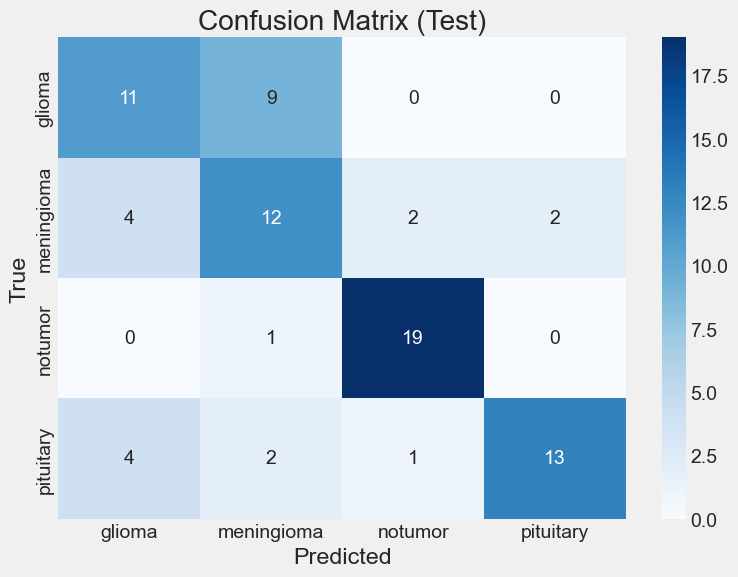

              precision    recall  f1-score   support

      glioma       0.58      0.55      0.56        20
  meningioma       0.50      0.60      0.55        20
     notumor       0.86      0.95      0.90        20
   pituitary       0.87      0.65      0.74        20

    accuracy                           0.69        80
   macro avg       0.70      0.69      0.69        80
weighted avg       0.70      0.69      0.69        80



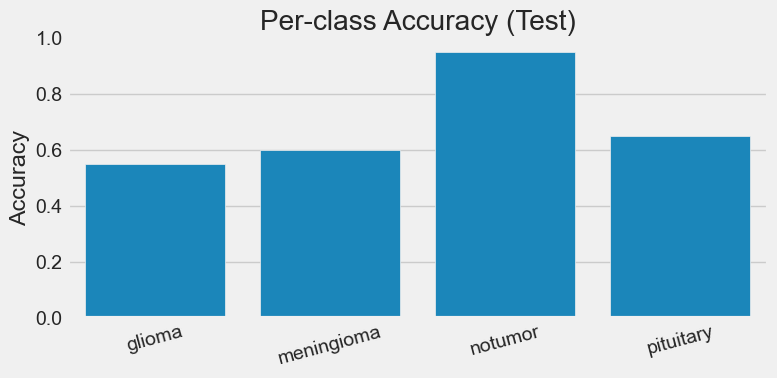

In [11]:
preds = model.predict(ts_gen, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = ts_gen.classes
labels = classes  # class names in index order

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# Text report
print(classification_report(y_true, y_pred, target_names=labels))

# Per-class accuracy bar chart
per_class_acc = (cm.diagonal() / cm.sum(axis=1).clip(min=1))
plt.figure(figsize=(8,4))
sns.barplot(x=labels, y=per_class_acc)
plt.ylim(0,1)
plt.title('Per-class Accuracy (Test)')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [12]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((128, 128))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


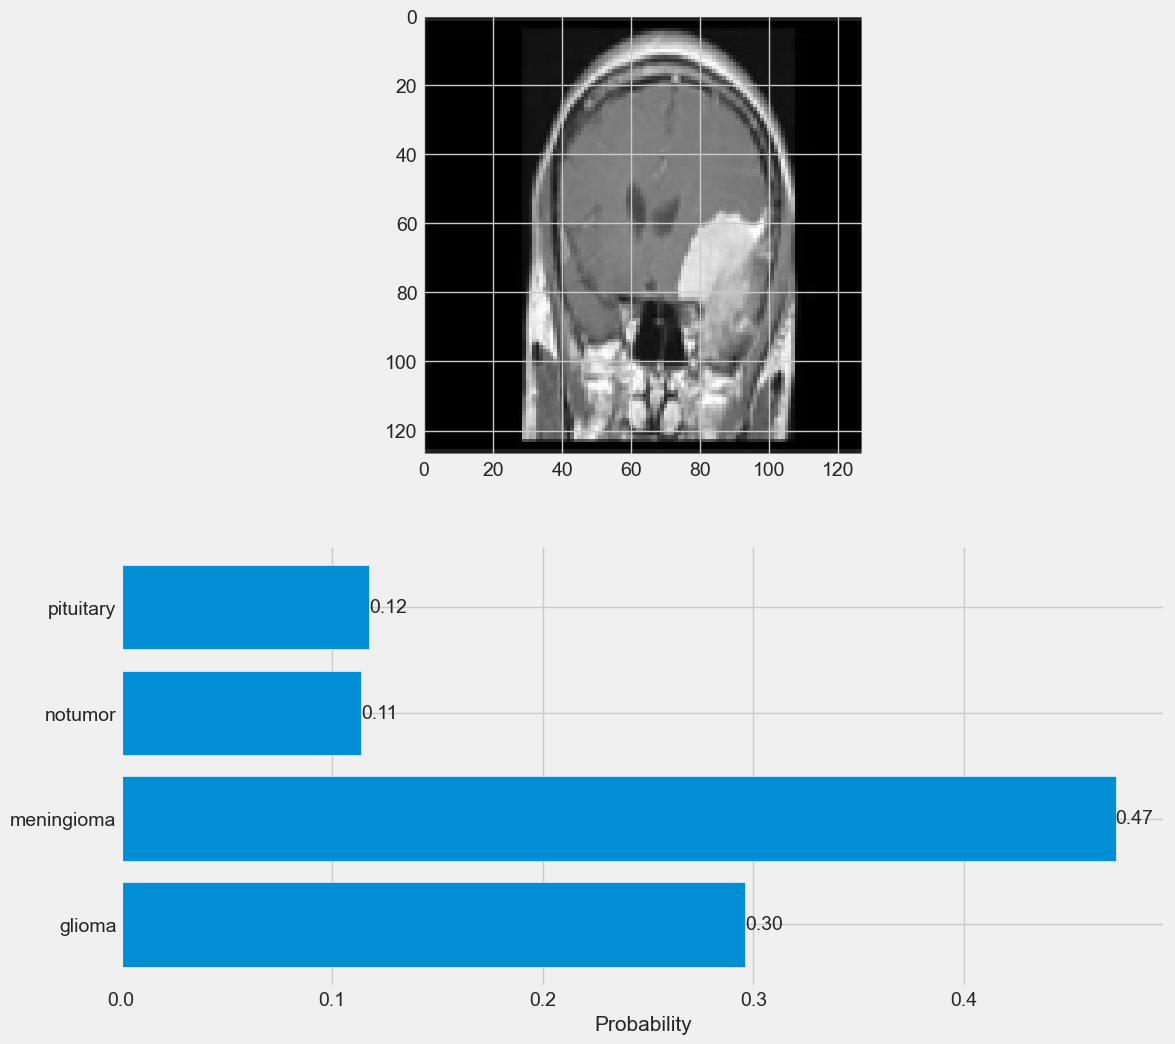

In [13]:
predict('input_data/Testing/meningioma/Te-meTr_0000.jpg')

Save the model

In [14]:
model.save('trained-model.keras');